### Dimensionality Reduction Comparison
#### Clustering Metric
The goal of this notebook is to come up with a metric that uses clustering at different levels of dimensionality to determine "nearby" interactions between cells and score transformed data based on the degree to which those distances are preserved in relation to un-reduced data.

In [1]:
import fcc_utils

import numpy as np
import scipy as sc
import pandas as pd

# package for reading in data files
import h5py

# scikit packages
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# import tsne packages
from sklearn.manifold import TSNE

# import density peak clustering
from pydpc import Cluster

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'white')
%matplotlib inline

In [ ]:
# read in an example dataset from Bob
AS1_1291 = fcc_utils.read_hdf5('inputs/Adj-Norm-1291-AS1.h5')

In [ ]:
AS1_1291.keys()

In [ ]:
print('Counts shape: {}\nTranscript labels shape: {}\n'.format(AS1_1291['counts_0'].shape, AS1_1291['transcripts_0'].shape))

So this data is of shape *(n_cells, n_genes)*, and the genes are labeled nicely for us in the `AS1_1291['transcripts_0']` vector.

In [ ]:
# let's take a subset of this data so it isn't too computationally expensive
AS1_1291_1 = AS1_1291['counts_0'][np.random.choice(AS1_1291['counts_0'].shape[0], size=500)]

AS1_1291_1.shape # confirm it's the right shape = (size, 32854)

In [ ]:
# save csv with results for DCA analysis later
values = AS1_1291_1.T
index = ['Row'+str(i) for i in range(1, len(values)+1)]

df = pd.DataFrame(values, index=index)

df.to_csv('inputs/AS1_1291_1.csv')

In [ ]:
# normalize counts data using arcsinh transformation
AS1_1291_1_norm = fcc_utils.arcsinh_norm(AS1_1291_1, norm=True, scale=1000)

In [ ]:
# Perform PCA on subsample of 500 cells with 50 components
PCA_fit = PCA(n_components=100).fit(AS1_1291_1_norm)
# transform data to fit
PCA_results = PCA_fit.transform(AS1_1291_1_norm)

# Plot PCA
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(PCA_results[:,0], PCA_results[:,1], s=75)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('PCA')

plt.subplot(122)
plt.plot(np.cumsum(np.round(PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - sinh-transformed')

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
clu = Cluster(PCA_results) # cluster using pydpc

In [ ]:
clu.assign(20,50) # assign cluster centers; looks like there's only one for this dataset

In [ ]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(PCA_results[:, 0], PCA_results[:, 1], s=40)
ax[0].scatter(PCA_results[clu.clusters, 0], PCA_results[clu.clusters, 1], s=50, c="red")
ax[1].scatter(PCA_results[:, 0], PCA_results[:, 1], s=40, c=clu.density)
ax[2].scatter(PCA_results[:, 0], PCA_results[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()

In [ ]:
# This uses perplexity=30 (default) and random initialisation
%time tSNE_results = TSNE(n_components=2).fit_transform(PCA_results)
# resulting matrix should be (375,2)
tSNE_results.shape

In [ ]:
# Plot tSNE
plt.figure(figsize=(5,5))

sns.scatterplot(tSNE_results[:,0], tSNE_results[:,1], s=75, legend=False)
plt.ylabel('t-SNE2')
plt.xlabel('t-SNE1')
plt.title('t-SNE')
plt.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
clu = Cluster(tSNE_results.astype('double')) # cluster using pydpc

In [ ]:
clu.assign(5,5) # assign cluster centers; looks like there's only one for this dataset

In [ ]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(tSNE_results[:, 0], tSNE_results[:, 1], s=40)
ax[0].scatter(tSNE_results[clu.clusters, 0], tSNE_results[clu.clusters, 1], s=50, c="red")
ax[1].scatter(tSNE_results[:, 0], tSNE_results[:, 1], s=40, c=clu.density)
ax[2].scatter(tSNE_results[:, 0], tSNE_results[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()

---
#### Look at DCA results
DCA was performed on same data as above from terminal with the following command:  
```
dca inputs/AS1_1291_1.csv outputs/DCA_results_AS1_1291_1
```

In [ ]:
# get output from DCA. should be in 32-dimensional space
reduced = np.ndfromtxt('outputs/DCA_results_AS1_1291_1/reduced.tsv')
reduced.shape

In [ ]:
clu = Cluster(reduced) # cluster using pydpc

In [ ]:
clu.assign(1,50) # assign cluster centers

In [ ]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(reduced[:, 0], reduced[:, 1], s=40)
ax[0].scatter(reduced[clu.clusters, 0], reduced[clu.clusters, 1], s=50, c="red")
ax[1].scatter(reduced[:, 0], reduced[:, 1], s=40, c=clu.density)
ax[2].scatter(reduced[:, 0], reduced[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()

In [ ]:
# plot first two dimensions of DCA, colored by clusters from PCA/KMeans above
plt.figure(figsize=(5,5))
sns.scatterplot(reduced[:,1],reduced[:,2],s=75, hue=clu.membership, legend=False)
plt.title('DCA, PCA clusters')
plt.xlabel('DCA1')
plt.ylabel('DCA2')
plt.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
plt.tight_layout()

Looks like you could visualize this reduction with a t-SNE plot.  
Perform t-SNE as before, using DCA to prime instead of PCA.

In [ ]:
# This uses perplexity=30 (default) and random initialisation
%time tSNE_DCA_results = TSNE(n_components=2).fit_transform(reduced[:,1:])
# resulting matrix should be (n_cells,2)
tSNE_DCA_results.shape

In [ ]:
# Plot tSNE
plt.figure(figsize=(5,5))

sns.scatterplot(tSNE_DCA_results[:,0], tSNE_DCA_results[:,1], s=75, legend=False)
plt.ylabel('t-SNE2')
plt.xlabel('t-SNE1')
plt.title('t-SNE')
plt.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
clu = Cluster(tSNE_DCA_results.astype('double')) # cluster using pydpc

In [ ]:
clu.assign(10,5) # assign cluster centers; looks like there's only one for this dataset

In [ ]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(tSNE_DCA_results[:, 0], tSNE_DCA_results[:, 1], s=40)
ax[0].scatter(tSNE_DCA_results[clu.clusters, 0], tSNE_DCA_results[clu.clusters, 1], s=50, c="red")
ax[1].scatter(tSNE_DCA_results[:, 0], tSNE_DCA_results[:, 1], s=40, c=clu.density)
ax[2].scatter(tSNE_DCA_results[:, 0], tSNE_DCA_results[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()

---
Read in another dataset from scVI example data to see if we get better clustering

In [2]:
umi_rna = pd.read_csv('inputs/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv',index_col=0)
umi_rna

,Barcode1,Barcode2,Barcode3,Barcode4,Barcode5,Barcode6,Barcode7,Barcode8,Barcode9,Barcode10,...,Barcode41,Barcode42,Barcode43,Barcode44,Barcode45,Barcode46,Barcode47,Barcode48,Barcode49,Barcode50
MOUSE_ACTB,243,410,321,351,534,221,630,220,142,304,...,225,189,173,1474,245,140,245,467,2205,250
MOUSE_CCL2,4,1853,2,0,25,59,1,24,21,4,...,0,5,2,8,23,1,21,0,3,6
MOUSE_MALAT1,757,579,543,575,734,426,283,487,422,529,...,346,349,705,1054,355,860,317,387,1056,342
MOUSE_S100A6,863,233,562,870,657,773,1069,826,1017,889,...,963,335,1085,393,732,365,581,875,249,489
MOUSE_TMSB4X,368,995,300,527,467,306,274,112,298,395,...,474,247,197,441,246,124,459,273,285,428
MOUSE_LGALS1,940,530,1094,1056,684,1028,1151,951,1135,857,...,855,686,892,736,899,353,686,799,337,751
MOUSE_FTH1,293,386,351,257,760,291,565,293,561,426,...,451,387,569,275,346,531,372,380,990,355
MOUSE_ACTA2,69,547,82,27,575,204,31,8,46,58,...,97,35,3,218,105,7,2,141,166,7
MOUSE_MT-ND1,403,943,451,426,731,447,515,392,588,632,...,432,697,460,443,539,558,641,329,971,470
MOUSE_MT-CYTB,341,597,315,362,570,340,460,277,453,505,...,267,486,310,235,427,433,394,292,438,365


In [3]:
# extract data from pandas dataframe as np.ndarray
umi_rna_vals = np.ascontiguousarray(umi_rna.values.T, dtype='double')

# normalize counts data using arcsinh transformation
umi_rna_norm = fcc_utils.arcsinh_norm(umi_rna_vals, norm=True, scale=1000)

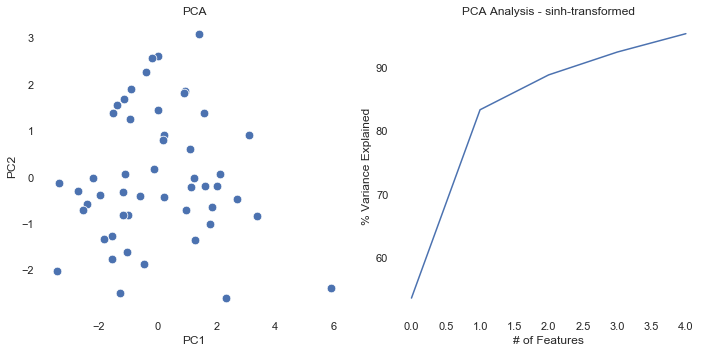

In [4]:
# Perform PCA
umi_rna_PCA_fit = PCA(n_components=5).fit(umi_rna_norm)
# transform data to fit
umi_rna_PCA_results = umi_rna_PCA_fit.transform(umi_rna_norm)

# Plot PCA
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(umi_rna_PCA_results[:,0], umi_rna_PCA_results[:,1], s=75)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('PCA')

plt.subplot(122)
plt.plot(np.cumsum(np.round(umi_rna_PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - sinh-transformed')

sns.despine(left=True, bottom=True)
plt.tight_layout()

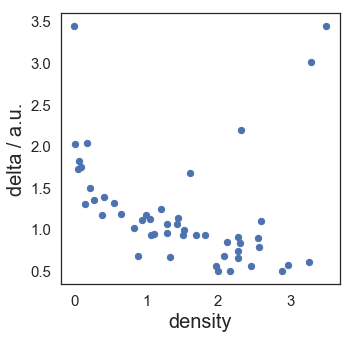

In [5]:
clu = Cluster(umi_rna_PCA_results) # perform density peak clustering on PCA for umi dataset

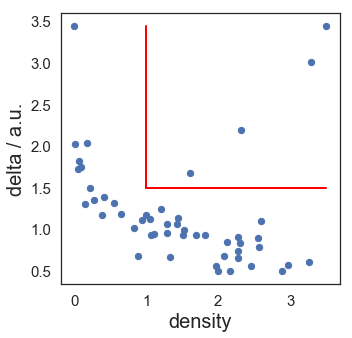

In [6]:
clu.assign(1,1.5) # assign cluster centers; looks like there's only one for this dataset

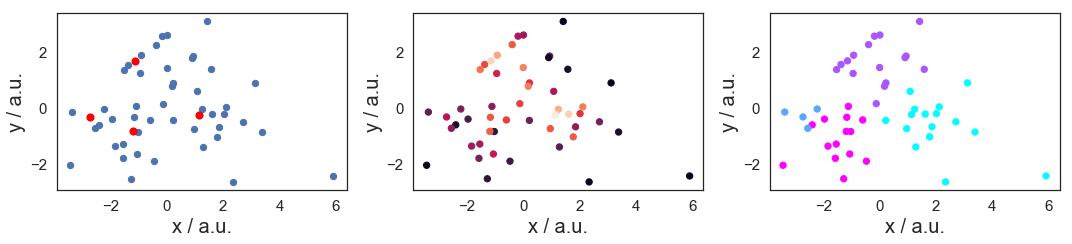

In [7]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(umi_rna_PCA_results[:, 0], umi_rna_PCA_results[:, 1], s=40)
ax[0].scatter(umi_rna_PCA_results[clu.clusters, 0], umi_rna_PCA_results[clu.clusters, 1], s=50, c="red")
ax[1].scatter(umi_rna_PCA_results[:, 0], umi_rna_PCA_results[:, 1], s=40, c=clu.density)
ax[2].scatter(umi_rna_PCA_results[:, 0], umi_rna_PCA_results[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()

---
Read in another dataset from **p-Creode** example data to see if we get better clustering

In [9]:
myeloid = pd.read_csv('inputs/Myeloid_with_IDs.csv')

In [10]:
# extract data from pandas dataframe as np.ndarray
myeloid_vals = np.ascontiguousarray(myeloid.values.T, dtype='double')

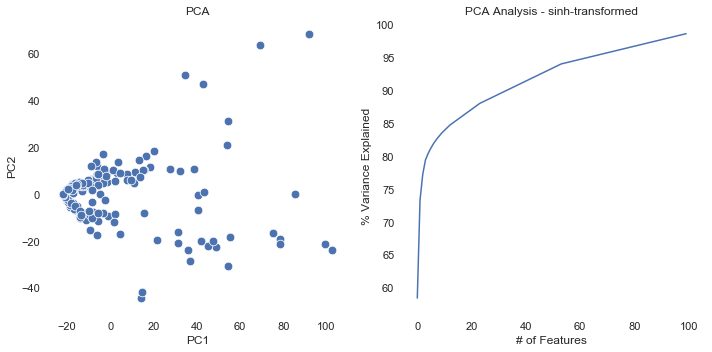

In [11]:
# Perform PCA
myeloid_PCA_fit = PCA(n_components=100).fit(myeloid_vals)
# transform data to fit
myeloid_PCA_results = myeloid_PCA_fit.transform(myeloid_vals)

# Plot PCA
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(myeloid_PCA_results[:,0], myeloid_PCA_results[:,1], s=75)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('PCA')

plt.subplot(122)
plt.plot(np.cumsum(np.round(myeloid_PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - sinh-transformed')

sns.despine(left=True, bottom=True)
plt.tight_layout()

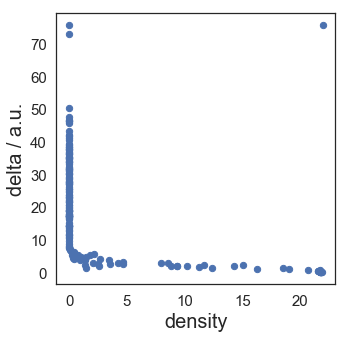

In [16]:
clu = Cluster(myeloid_PCA_results) # perform density peak clustering on PCA for myeloid dataset

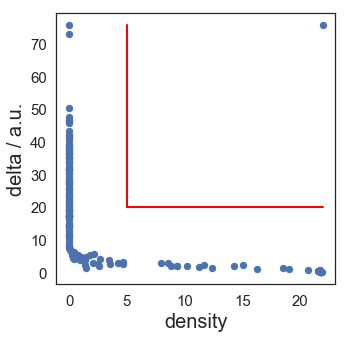

In [17]:
clu.assign(5,20) # assign cluster centers; looks like there's only one for this dataset

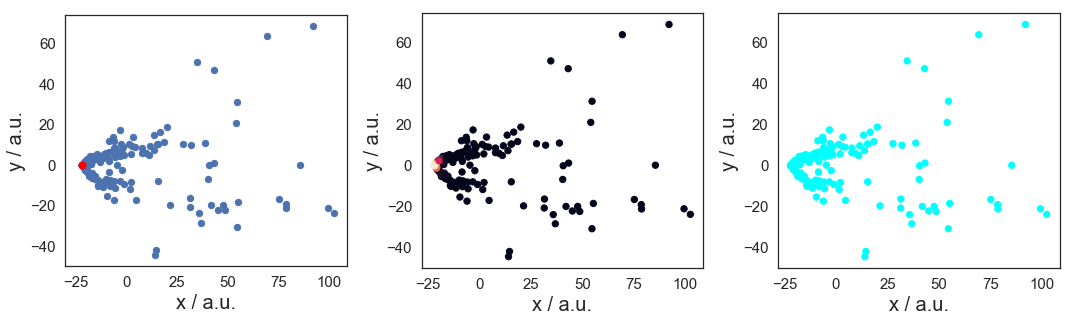

In [19]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(myeloid_PCA_results[:, 0], myeloid_PCA_results[:, 1], s=40)
ax[0].scatter(myeloid_PCA_results[clu.clusters, 0], myeloid_PCA_results[clu.clusters, 1], s=50, c="red")
ax[1].scatter(myeloid_PCA_results[:, 0], myeloid_PCA_results[:, 1], s=40, c=clu.density)
ax[2].scatter(myeloid_PCA_results[:, 0], myeloid_PCA_results[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()

In [20]:
# perform t-SNE on these data 
%time myeloid_tSNE_results = TSNE(n_components=2).fit_transform(myeloid_PCA_results)

CPU times: user 824 ms, sys: 18 ms, total: 842 ms
Wall time: 834 ms


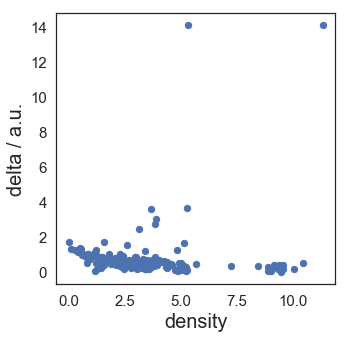

In [24]:
clu = Cluster(myeloid_tSNE_results.astype('double')) # perform density peak clustering on tSNE for myeloid dataset

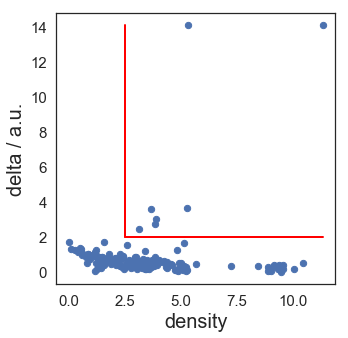

In [25]:
clu.assign(2.5,2) # assign cluster centers; looks like there's only one for this dataset

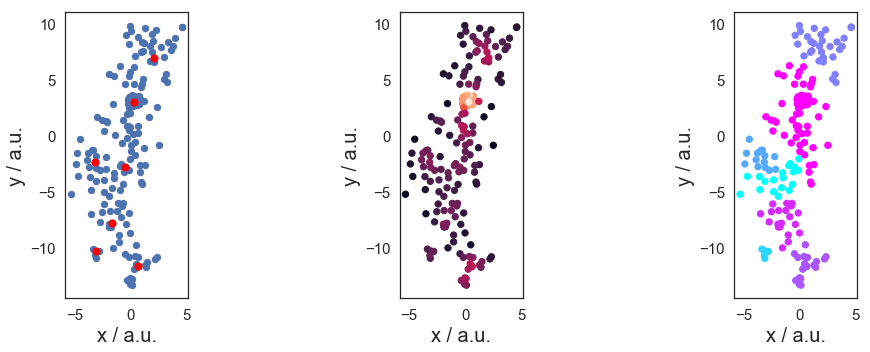

In [26]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(myeloid_tSNE_results[:, 0], myeloid_tSNE_results[:, 1], s=40)
ax[0].scatter(myeloid_tSNE_results[clu.clusters, 0], myeloid_tSNE_results[clu.clusters, 1], s=50, c="red")
ax[1].scatter(myeloid_tSNE_results[:, 0], myeloid_tSNE_results[:, 1], s=40, c=clu.density)
ax[2].scatter(myeloid_tSNE_results[:, 0], myeloid_tSNE_results[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()

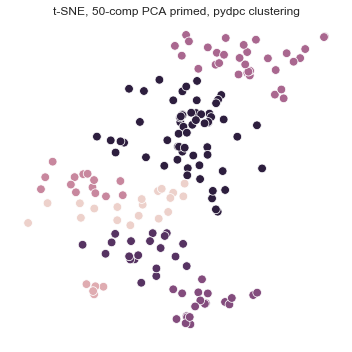

In [27]:
# plot results
plt.figure(figsize=(5,5))

sns.scatterplot(myeloid_tSNE_results[:,0], myeloid_tSNE_results[:,1], s=75, hue=clu.membership, legend=False)
plt.title('t-SNE, 50-comp PCA primed, pydpc clustering')
plt.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
Read in another dataset from **p-Creode** example data to see if we get better clustering

In [ ]:
AS1 = fcc_utils.read_hdf5('inputs/Adj-Norm-1291-AS1.h5')

In [ ]:
AS1.keys()

In [ ]:
print('Counts shape: {}\nTranscript labels shape: {}\n'.format(AS1['counts_0'].shape, AS1['transcripts_0'].shape))

So this data is of shape *(n_cells, n_genes)*, and the genes are labeled nicely for us in the `AS1_1291['transcripts_0']` vector.

In [ ]:
# let's take a subset of this data so it isn't too computationally expensive
AS1_1291_1 = AS1_1291['counts_0'][np.random.choice(AS1_1291['counts_0'].shape[0], size=10000)]

AS1_1291_1.shape # confirm it's the right shape = (size, 32854)

In [ ]:
# normalize counts data using arcsinh transformation
AS1_1291_1_norm = fcc_utils.arcsinh_norm(AS1_1291_1, norm=True, scale=1000)

In [ ]:
# extract data from pandas dataframe as np.ndarray
myeloid_vals = np.ascontiguousarray(myeloid.values.T, dtype='double')

In [ ]:
# Perform PCA
myeloid_PCA_fit = PCA(n_components=100).fit(myeloid_vals)
# transform data to fit
myeloid_PCA_results = myeloid_PCA_fit.transform(myeloid_vals)

# Plot PCA
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(myeloid_PCA_results[:,0], myeloid_PCA_results[:,1], s=75)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('PCA')

plt.subplot(122)
plt.plot(np.cumsum(np.round(myeloid_PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - sinh-transformed')

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [ ]:
clu = Cluster(myeloid_PCA_results) # perform density peak clustering on PCA for myeloid dataset

In [ ]:
clu.assign(5,20) # assign cluster centers; looks like there's only one for this dataset

In [ ]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(umi_rna_PCA_results[:, 0], umi_rna_PCA_results[:, 1], s=40)
ax[0].scatter(umi_rna_PCA_results[clu.clusters, 0], umi_rna_PCA_results[clu.clusters, 1], s=50, c="red")
ax[1].scatter(umi_rna_PCA_results[:, 0], umi_rna_PCA_results[:, 1], s=40, c=clu.density)
ax[2].scatter(umi_rna_PCA_results[:, 0], umi_rna_PCA_results[:, 1], s=40, c=clu.membership, cmap=plt.cm.cool)
for _ax in ax:
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
fig.tight_layout()